Real N=200 | Pseudo N=200
Means: Real(min)=16.1785, Real(avg)=20.8601, Pseudo(min)=28.3705, Pseudo(avg)=33.8043


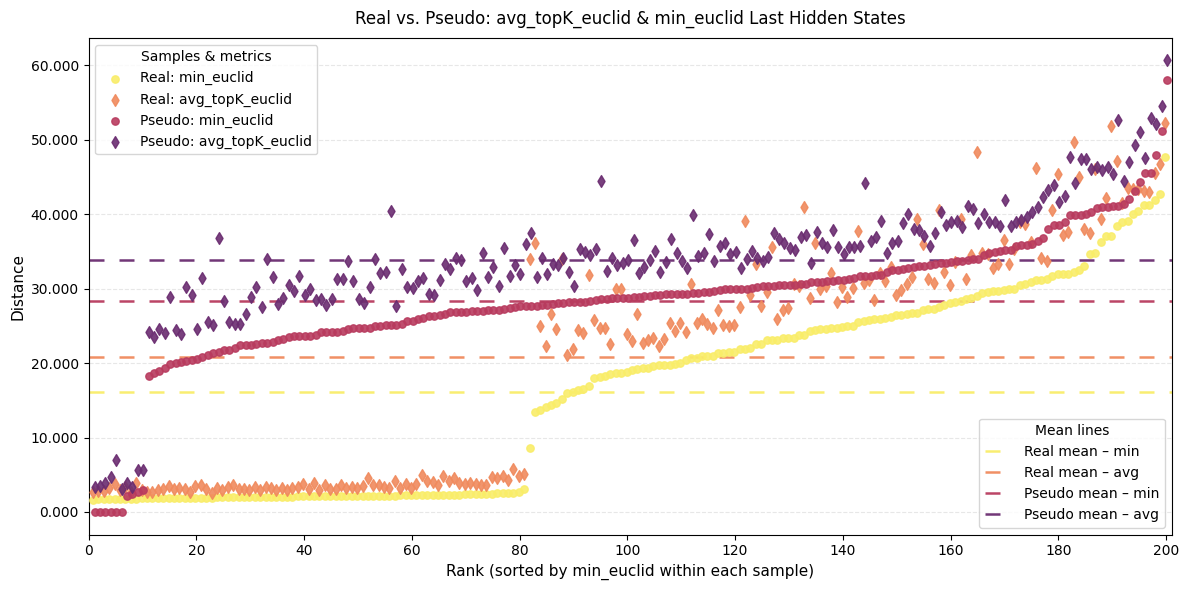

In [17]:
# -*- coding: utf-8 -*-
# Compare real vs. pseudo words on avg_topK_euclid and min_euclid.
# X-axis: rank index after sorting BY min_euclid (ascending) within each file.
# Y-axis: raw values. Each rank shows two points per dataset (avg_topK_euclid & min_euclid).
# Colors:
#   Real:   min_euclid = #27374D, avg_topK_euclid = #526D82
#   Pseudo: min_euclid = #B1B2FF, avg_topK_euclid = #AAC4FF

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --------- EDIT THESE PATHS ----------
real_csv   = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/real_sort/rank_euclid_avgTop200__last_mean.csv"    # first file (real words)
pseudo_csv = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/sort_candidate/rank_euclid_avgTop200__last_mean.csv"  # second file (pseudo words)

"""real_csv   = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/real_sort/rank_euclid_avgTop200__embedding.csv"    # first file (real words)
pseudo_csv = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/sort_candidate/rank_euclid_avgTop200__embedding.csv"  # second file (pseudo words)"""

# -------------------------------------

JITTER_REAL   = -0.15
JITTER_PSEUDO =  0.15

# Marker shapes & sizes
MARKER_SIZE_MIN = 28  # circle for min_euclid
MARKER_SIZE_AVG = 36  # diamond for avg_topK_euclid
MARKER_MIN = "o"
MARKER_AVG = "d"

ALPHA = 0.9

# Colors
REAL_MIN   = "#F9ED69"  # Real min_euclid
REAL_AVG   = "#F08A5D"  # Real avg_topK_euclid
PSEU_MIN   = "#B83B5E"  # Pseudo min_euclid
PSEU_AVG   = "#6A2C70"  # Pseudo avg_topK_euclid

# Mean line style
MEAN_LINESTYLE = (0, (6, 6))
MEAN_LINEWIDTH = 1.8

def load_and_rank(path: str) -> pd.DataFrame:
    assert os.path.exists(path), f"CSV not found: {path}"
    df = pd.read_csv(path)
    if "avg_topK_euclid" not in df.columns and "avg_topK" in df.columns:
        df = df.rename(columns={"avg_topK": "avg_topK_euclid"})
    required = {"avg_topK_euclid", "min_euclid"}
    missing = required - set(df.columns)
    if missing:
        raise KeyError(f"Missing columns: {missing}")
    df = df[list(required)].dropna()
    df = df.sort_values("min_euclid", ascending=True).reset_index(drop=True)
    df.insert(0, "rank", np.arange(1, len(df) + 1))
    return df

real_df = load_and_rank(real_csv)
pseudo_df = load_and_rank(pseudo_csv)

fig, ax = plt.subplots(figsize=(12, 6))

# Points — REAL
h_real_min = ax.scatter(
    real_df["rank"] + JITTER_REAL, real_df["min_euclid"],
    s=MARKER_SIZE_MIN, color=REAL_MIN, alpha=ALPHA, marker=MARKER_MIN,
    label="Real: min_euclid", zorder=3,
)
h_real_avg = ax.scatter(
    real_df["rank"] + JITTER_REAL, real_df["avg_topK_euclid"],
    s=MARKER_SIZE_AVG, color=REAL_AVG, alpha=ALPHA, marker=MARKER_AVG,
    label="Real: avg_topK_euclid", zorder=3,
)

# Points — PSEUDO
h_pseu_min = ax.scatter(
    pseudo_df["rank"] + JITTER_PSEUDO, pseudo_df["min_euclid"],
    s=MARKER_SIZE_MIN, color=PSEU_MIN, alpha=ALPHA, marker=MARKER_MIN,
    label="Pseudo: min_euclid", zorder=3,
)
h_pseu_avg = ax.scatter(
    pseudo_df["rank"] + JITTER_PSEUDO, pseudo_df["avg_topK_euclid"],
    s=MARKER_SIZE_AVG, color=PSEU_AVG, alpha=ALPHA, marker=MARKER_AVG,
    label="Pseudo: avg_topK_euclid", zorder=3,
)

# Axes/labels
ax.set_xlabel("Rank (sorted by min_euclid within each sample)", fontsize=11)
ax.set_ylabel("Distance", fontsize=11)
ax.set_title("Real vs. Pseudo: avg_topK_euclid & min_euclid Last Hidden States", fontsize=12, pad=10)

max_rank = max(real_df["rank"].max(), pseudo_df["rank"].max())
ax.set_xlim(0, max_rank + 1)
xtick_step = max(1, max_rank // 10)
ax.set_xticks(np.arange(0, max_rank + 1, xtick_step))
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:,.3f}" if abs(y) < 1000 else f"{int(y):,}"))
ax.grid(axis="y", linestyle="--", alpha=0.3)

# Mean lines (legend only, no inline text)
real_min_mean = real_df["min_euclid"].mean()
real_avg_mean = real_df["avg_topK_euclid"].mean()
pseu_min_mean = pseudo_df["min_euclid"].mean()
pseu_avg_mean = pseudo_df["avg_topK_euclid"].mean()

h_line_real_min = ax.axhline(real_min_mean, color=REAL_MIN, linestyle=MEAN_LINESTYLE, linewidth=MEAN_LINEWIDTH, alpha=0.95, label="Real mean – min")
h_line_real_avg = ax.axhline(real_avg_mean, color=REAL_AVG, linestyle=MEAN_LINESTYLE, linewidth=MEAN_LINEWIDTH, alpha=0.95, label="Real mean – avg")
h_line_pseu_min = ax.axhline(pseu_min_mean, color=PSEU_MIN, linestyle=MEAN_LINESTYLE, linewidth=MEAN_LINEWIDTH, alpha=0.95, label="Pseudo mean – min")
h_line_pseu_avg = ax.axhline(pseu_avg_mean, color=PSEU_AVG, linestyle=MEAN_LINESTYLE, linewidth=MEAN_LINEWIDTH, alpha=0.95, label="Pseudo mean – avg")

# Legends
points_legend = ax.legend(
    handles=[h_real_min, h_real_avg, h_pseu_min, h_pseu_avg],
    loc="upper left", frameon=True, title="Samples & metrics"
)
ax.add_artist(points_legend)

lines_legend = ax.legend(
    handles=[h_line_real_min, h_line_real_avg, h_line_pseu_min, h_line_pseu_avg],
    loc="lower right", frameon=True, title="Mean lines"
)

plt.tight_layout()
# plt.savefig("/tmp/euclid_rank_compare_two_legends_no_inline.png", dpi=180, bbox_inches="tight")
# plt.show()

print(f"Real N={len(real_df)} | Pseudo N={len(pseudo_df)}")
print(f"Means: Real(min)={real_min_mean:.4f}, Real(avg)={real_avg_mean:.4f}, "
      f"Pseudo(min)={pseu_min_mean:.4f}, Pseudo(avg)={pseu_avg_mean:.4f}")


Real N=200 | Pseudo N=200
Means: Real(max)=0.6695, Real(avg)=0.3053, Pseudo(max)=0.6157, Pseudo(avg)=0.3175


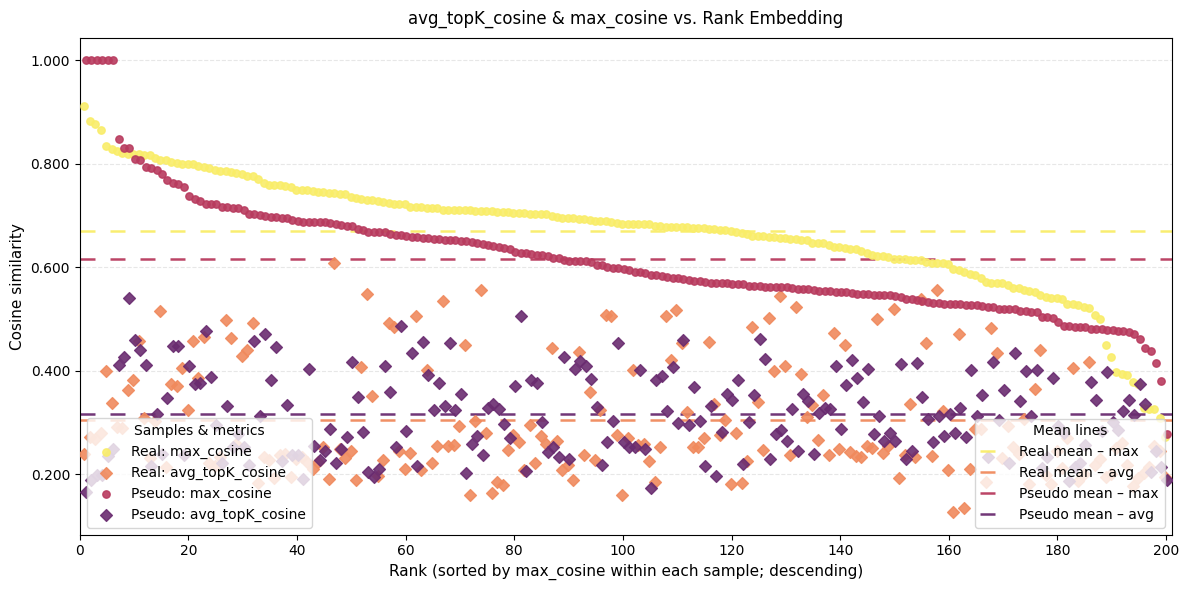

In [27]:
# -*- coding: utf-8 -*-
# Cosine-version of the Euclid plot with the SAME style:
# - X-axis: rank after sorting by min_cosine (ascending) within each dataset.
# - Y-axis: raw cosine metric values (e.g., cosine distance).
# - Two markers per rank: circle for min_cosine, diamond for avg_topK_cosine.
# - Colors:
#     Real:   min_cosine = #27374D, avg_topK_cosine = #526D82
#     Pseudo: min_cosine = #B1B2FF, avg_topK_cosine = #AAC4FF
# - Two legends: (1) points (upper-left), (2) mean lines (lower-right).
# - No inline labels on the mean lines.

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# --------- EDIT THESE PATHS ----------
real_csv   = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/real_sort/rank_cosine_avgTop200__last_mean.csv"    # real words
pseudo_csv = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/sort_candidate/rank_cosine_avgTop200__last_mean.csv"  # pseudo words


real_csv   = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/real_sort/rank_cosine_avgTop200__embedding.csv"    # real words
pseudo_csv = "/Users/zhzhou/Desktop/SafeContextualReward/results/word_synthesis/v4_rpj_llama_s4/sort_candidate/rank_cosine_avgTop200__embedding.csv"  # pseudo words



# Visual params (kept consistent with your Euclid plot)
JITTER_REAL   = -0.15
JITTER_PSEUDO =  0.15
MARKER_SIZE_MAX = 28  # circle for max_cosine
MARKER_SIZE_AVG = 36  # diamond for avg_topK_cosine
MARKER_MAX = "o"
MARKER_AVG = "D"
ALPHA = 0.9

REAL_MAX   = "#F9ED69"  # Real min_euclid
REAL_AVG   = "#F08A5D"  # Real avg_topK_euclid
PSEU_MAX  = "#B83B5E"  # Pseudo min_euclid
PSEU_AVG   = "#6A2C70"  # Pseudo avg_topK_euclid


# Mean line style
MEAN_LINESTYLE = (0, (6, 6))
MEAN_LINEWIDTH = 1.8

def _resolve_col(df: pd.DataFrame, candidates, rename_to):
    """Find the first existing column in `candidates` and rename it to `rename_to`."""
    for c in candidates:
        if c in df.columns:
            if c != rename_to:
                df = df.rename(columns={c: rename_to})
            return df
    raise KeyError(f"None of the columns found for {rename_to}: {candidates}")

def load_and_rank(path: str) -> pd.DataFrame:
    assert os.path.exists(path), f"CSV not found: {path}"
    df = pd.read_csv(path)

    # Normalize column names to `avg_topK_cosine` and `max_cosine`
    df = _resolve_col(df, ["avg_topK_cosine", "avg_topK", "avgTopK_cosine"], "avg_topK_cosine")
    df = _resolve_col(df, ["max_cosine", "maxCosine", "cosine_max", "max"], "max_cosine")

    df = df[["avg_topK_cosine", "max_cosine"]].dropna()

    # Sort by max_cosine DESC (largest similarity first)
    df = df.sort_values("max_cosine", ascending=False).reset_index(drop=True)
    df.insert(0, "rank", np.arange(1, len(df) + 1))
    return df

real_df = load_and_rank(real_csv)
pseudo_df = load_and_rank(pseudo_csv)

fig, ax = plt.subplots(figsize=(12, 6))

# --- Scatter points ---
# REAL
h_real_max = ax.scatter(
    real_df["rank"] + JITTER_REAL, real_df["max_cosine"],
    s=MARKER_SIZE_MAX, color=REAL_MAX, alpha=ALPHA, marker=MARKER_MAX,
    label="Real: max_cosine", zorder=3,
)
h_real_avg = ax.scatter(
    real_df["rank"] + JITTER_REAL, real_df["avg_topK_cosine"],
    s=MARKER_SIZE_AVG, color=REAL_AVG, alpha=ALPHA, marker=MARKER_AVG,
    label="Real: avg_topK_cosine", zorder=3,
)

# PSEUDO
h_pseu_max = ax.scatter(
    pseudo_df["rank"] + JITTER_PSEUDO, pseudo_df["max_cosine"],
    s=MARKER_SIZE_MAX, color=PSEU_MAX, alpha=ALPHA, marker=MARKER_MAX,
    label="Pseudo: max_cosine", zorder=3,
)
h_pseu_avg = ax.scatter(
    pseudo_df["rank"] + JITTER_PSEUDO, pseudo_df["avg_topK_cosine"],
    s=MARKER_SIZE_AVG, color=PSEU_AVG, alpha=ALPHA, marker=MARKER_AVG,
    label="Pseudo: avg_topK_cosine", zorder=3,
)

# Axes/labels
ax.set_xlabel("Rank (sorted by max_cosine within each sample; descending)", fontsize=11)
ax.set_ylabel("Cosine similarity", fontsize=11)
ax.set_title("avg_topK_cosine & max_cosine vs. Rank Embedding", fontsize=12, pad=10)

# X limits / ticks
max_rank = max(real_df["rank"].max(), pseudo_df["rank"].max())
ax.set_xlim(0, max_rank + 1)
xtick_step = max(1, max_rank // 10)
ax.set_xticks(np.arange(0, max_rank + 1, xtick_step))
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter("{x:,.0f}"))

# Y ticks (cosine typically in [-1,1] or [0,1]); show with 3 decimals
ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.3f"))
ax.grid(axis="y", linestyle="--", alpha=0.3)

# --- Mean lines (legend only, no inline labels) ---
real_max_mean = real_df["max_cosine"].mean()
real_avg_mean = real_df["avg_topK_cosine"].mean()
pseu_max_mean = pseudo_df["max_cosine"].mean()
pseu_avg_mean = pseudo_df["avg_topK_cosine"].mean()

h_line_real_max = ax.axhline(real_max_mean, color=REAL_MAX, linestyle=MEAN_LINESTYLE, linewidth=MEAN_LINEWIDTH, alpha=0.95, label="Real mean – max")
h_line_real_avg = ax.axhline(real_avg_mean, color=REAL_AVG, linestyle=MEAN_LINESTYLE, linewidth=MEAN_LINEWIDTH, alpha=0.95, label="Real mean – avg")
h_line_pseu_max = ax.axhline(pseu_max_mean, color=PSEU_MAX, linestyle=MEAN_LINESTYLE, linewidth=MEAN_LINEWIDTH, alpha=0.95, label="Pseudo mean – max")
h_line_pseu_avg = ax.axhline(pseu_avg_mean, color=PSEU_AVG, linestyle=MEAN_LINESTYLE, linewidth=MEAN_LINEWIDTH, alpha=0.95, label="Pseudo mean – avg")

# Legends (separate)
points_legend = ax.legend(
    handles=[h_real_max, h_real_avg, h_pseu_max, h_pseu_avg],
    loc="lower left", frameon=True, title="Samples & metrics"
)
ax.add_artist(points_legend)

lines_legend = ax.legend(
    handles=[h_line_real_max, h_line_real_avg, h_line_pseu_max, h_line_pseu_avg],
    loc="lower right", frameon=True, title="Mean lines"
)

plt.tight_layout()
# plt.savefig("/tmp/cosine_rank_compare_two_legends.png", dpi=180, bbox_inches="tight")
# plt.show()

print(f"Real N={len(real_df)} | Pseudo N={len(pseudo_df)}")
print(f"Means: Real(max)={real_max_mean:.4f}, Real(avg)={real_avg_mean:.4f}, "
      f"Pseudo(max)={pseu_max_mean:.4f}, Pseudo(avg)={pseu_avg_mean:.4f}")
